# Logistic Regression

## Name: Samuel Goldrup

## Class: Math 403

## Date: 8 November 2022

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import statsmodels.api as sm
import time
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$. Now I'm going to push to prod.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [2]:
class LogiReg():
    """ input:
        y: nparray(n, 1) taking values only in {0,1}
        X: nparray(n, d)
    """
    
    def __init__(self, y, X):
        """
        Save y and X as attributes.
        """
        if len(y) != len(X):
            raise ValueError("dimension mismatch")
            
        self.n = X.shape[0]
        self.X = np.column_stack((np.ones(self.n),X))
        self.d = self.X.shape[1]
        self.y = y
        
    
    def fit(self):
        """
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        l = lambda b: np.sum([y[i]*np.log(1+np.exp(-self.X[i].T@b)) + (1-y[i])*np.log(1+np.exp(self.X[i].T@b)) for i in range(self.n)])
        self.b = minimize(l,np.ones(self.d)).x #MLE estimation

        
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        x_test_ones = np.column_stack((np.ones(len(x_test)),x_test)) #add 1's col
        sigmoid = lambda x: 1/(1+np.exp(-x@self.b)) #build sigmoid
        return sigmoid(x_test_ones)
    
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """
        probs = self.predict_prob(x_test)
        classified = np.zeros_like(probs) #get 0's and 1's
        classified[probs > 1/2] = 1 
        return classified

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

<IPython.core.display.Javascript object>


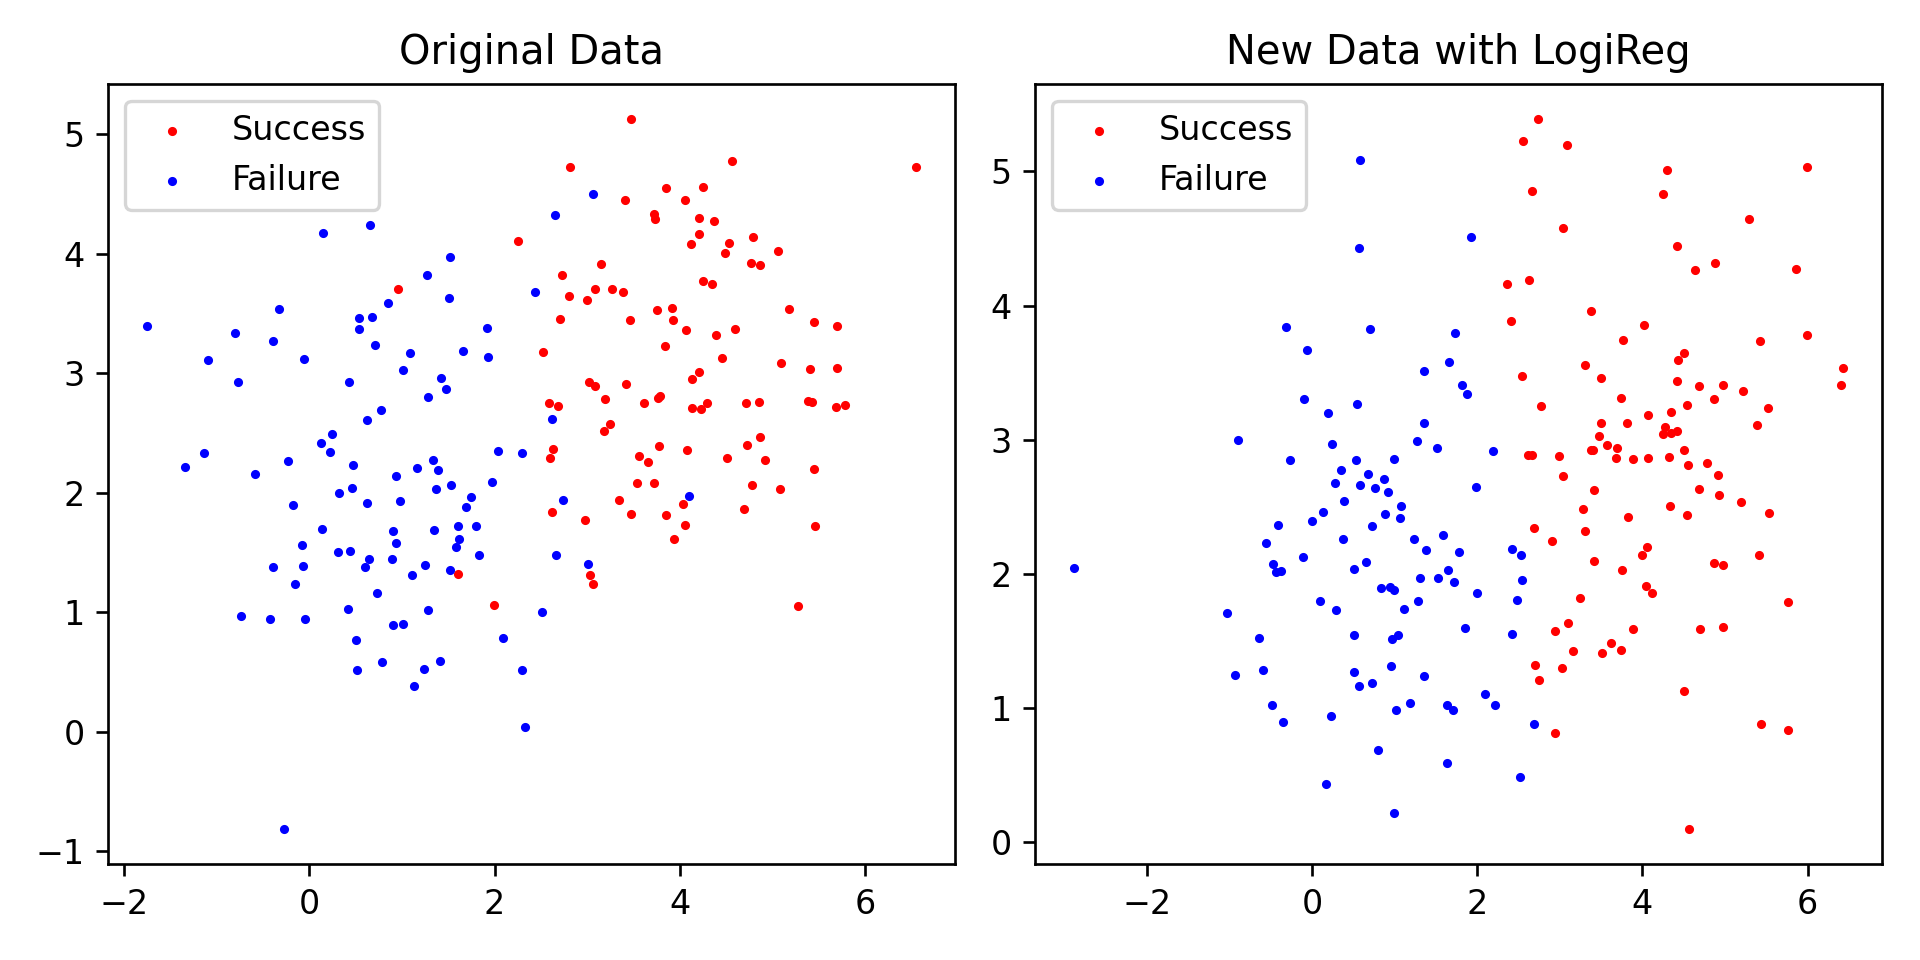

In [3]:
data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)

model = LogiReg(y,X)
model.fit()

predictions = model.predict(X_test)

indices_1_train = y == 1
indices_0_train = y == 0

indices_1_pred = predictions == 1 #classifications
indices_0_pred = predictions == 0

s = 3 #maker size

plt.figure(figsize=(8,4)) #figure size

plt.subplot(121).scatter(X[:,0][indices_1_train],X[:,1][indices_1_train],color="red",label="Success",s=s) #plot separately
plt.subplot(121).scatter(X[:,0][indices_0_train],X[:,1][indices_0_train],color="blue",label="Failure",s=s)
plt.legend()
plt.title("Original Data")

plt.subplot(122).scatter(X_test[:,0][indices_1_pred],X_test[:,1][indices_1_pred],color="red",label="Success",s=s)
plt.subplot(122).scatter(X_test[:,0][indices_0_pred],X_test[:,1][indices_0_pred],color="blue",label="Failure",s=s)
plt.title("New Data with LogiReg")
plt.legend()

plt.tight_layout()
plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels`, and `sklearn`, train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [4]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )


a = time.time() #timing
sm_X, sm_X_test = sm.add_constant(X), sm.add_constant(X_test) #add a constant
sm_model = sm.Logit(y,sm_X).fit_regularized()
probs = sm_model.predict(sm_X_test)
labels = list(map(round, probs)) #generate labels
sm_time = time.time() - a
sm_acc = accuracy_score(y_test,labels) #maybe need to mask

b = time.time() #timing
sk_model = LogisticRegression(fit_intercept=True).fit(X,y)
labels = sk_model.predict(X_test)
sk_time = time.time() - b
sk_acc = accuracy_score(y_test,labels)

c = time.time() #timing
model = LogiReg(y,X)
model.fit()
predictions = model.predict(X_test)
logi_time = time.time() - c
logi_acc = accuracy_score(y_test,predictions)

times = [sm_time, sk_time, logi_time]
accs = [sm_acc,sk_acc,logi_acc]

print(f"times\nstatsmodels: {times[0]}, sklearn: {times[1]}, logireg: {times[2]}")
print(f"accuracies\nstatsmodels: {accs[0]}, sklearn: {accs[1]}, logireg: {accs[2]}")

c:\miniconda\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.428142711706546e-11
            Iterations: 47
            Function evaluations: 49
            Gradient evaluations: 47
times
statsmodels: 0.13524937629699707, sklearn: 0.013809919357299805, logireg: 3.0149145126342773
accuracies
statsmodels: 0.94, sklearn: 0.915, logireg: 0.935


## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels.

In [5]:
iris_data = datasets.load_iris()

In [6]:
X = iris_data['data']
y = iris_data['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X[:,:2],y,test_size=0.4) #split

In [8]:
model = LogisticRegression(multi_class='multinomial',fit_intercept=True).fit(X_train,y_train) #fit model

In [9]:
predictions = model.predict(X_test)

<IPython.core.display.Javascript object>


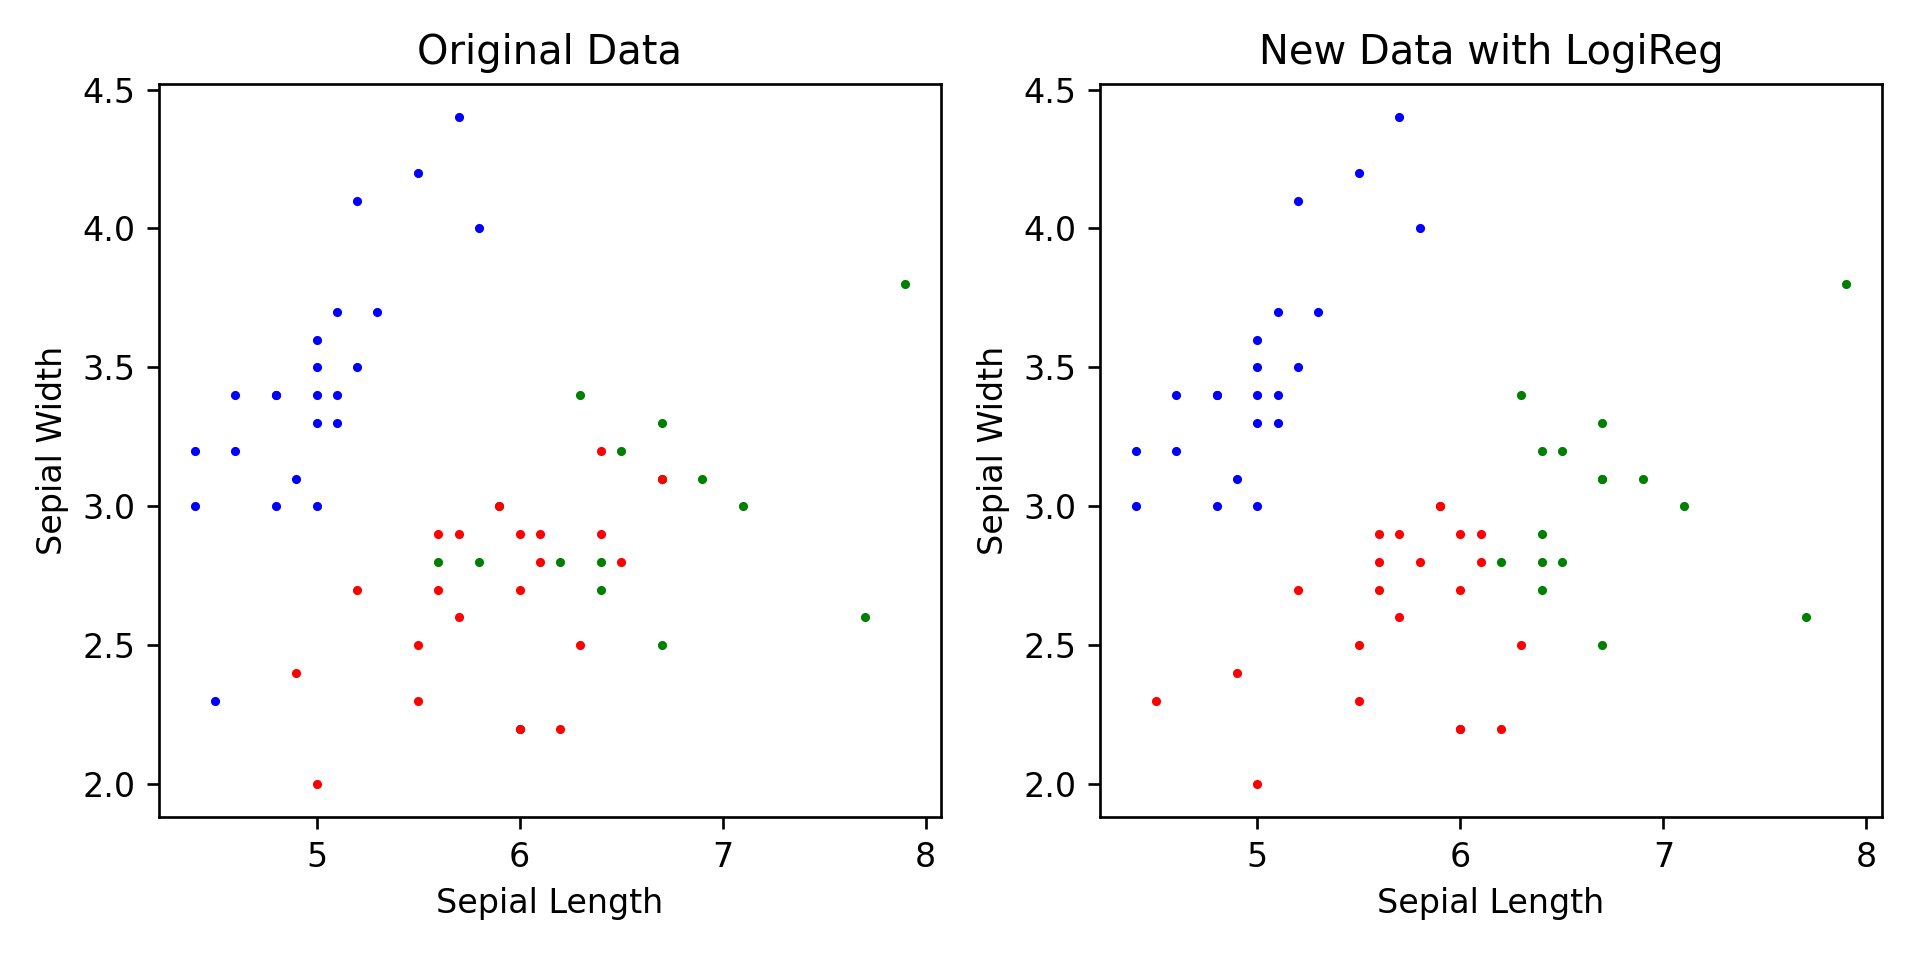

In [11]:
indices_2_test = y_test == 2 
indices_1_test = y_test == 1
indices_0_test = y_test == 0

indices_2_pred = predictions == 2 #classifications
indices_1_pred = predictions == 1
indices_0_pred = predictions == 0

s = 3 #maker size

plt.figure(figsize=(8,4)) #figure size

plt.subplot(121).scatter(X_test[:,0][indices_2_test],X_test[:,1][indices_2_test],color="green",s=s) #plot separately
plt.subplot(121).scatter(X_test[:,0][indices_1_test],X_test[:,1][indices_1_test],color="red",s=s)
plt.subplot(121).scatter(X_test[:,0][indices_0_test],X_test[:,1][indices_0_test],color="blue",s=s)
plt.xlabel("Sepial Length")
plt.ylabel("Sepial Width")
plt.title("Original Data")


plt.subplot(122).scatter(X_test[:,0][indices_2_pred],X_test[:,1][indices_2_pred],color="green",s=s)
plt.subplot(122).scatter(X_test[:,0][indices_1_pred],X_test[:,1][indices_1_pred],color="red",s=s)
plt.subplot(122).scatter(X_test[:,0][indices_0_pred],X_test[:,1][indices_0_pred],color="blue",s=s)
plt.xlabel("Sepial Length")
plt.xlabel("Sepial Length")
plt.ylabel("Sepial Width")
plt.title("New Data with LogiReg")

plt.tight_layout()
plt.show()